In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
import pandas as pd
import os
from itertools import combinations
from datetime import datetime
import seaborn as sb
from collections import Counter
from scipy.stats import linregress
from networkx.algorithms.community import modularity
def linbin_pdf(data, nbin=100, yinf=1e-6):
    import numpy as np

    mini, maxi = min(data), max(data)

    # Bines linealmente espaciados
    bines = np.linspace(mini, maxi, nbin)

    counts, bines = np.histogram(data, bins=bines, density=True)

    # Centros de los bines
    x = np.array([bines[i] + (bines[i+1] - bines[i]) * 0.5 for i in range(len(bines) - 1)])
    y = np.array(counts)

    # Filtro para evitar valores demasiado pequeños
    mask = y > yinf
    x = x[mask]
    y = y[mask]

    return x, y

In [2]:
from models.construir_red import construir_red_global_sentimientos
G=construir_red_global_sentimientos(n_videos_por_canal=200,umbral_similitud=0,cantidad_aristas=80)

# Grafo Canales

In [3]:
from models.construir_red import construir_red_global_sentimientos_canales
G_canales= construir_red_global_sentimientos_canales(umbral_similitud=0)

In [4]:
# === Crear carpeta de salida ===
output_dir = "grafo_grados_sent"
os.makedirs(output_dir, exist_ok=True)


# === Bucle principal ===
for p in [10, 20, 30, 40, 50, 60, 70]:
    G1 = construir_red_global_sentimientos(
        n_videos_por_canal=100,
        umbral_similitud=0,
        cantidad_aristas=p
    )

    num_componentes = nx.number_connected_components(G1)
    n = G1.number_of_nodes()
    aristas_totales = n * (n - 1) / 2

    print(f"\n--- {p}% de aristas ---")
    print(f"Nodos: {n}")
    print(f"Cantidad de aristas totales posibles: {aristas_totales}")
    print(f"Cantidad de aristas consideradas: {aristas_totales * (p / 100)}")
    print(f"Cantidad de componentes conexas: {num_componentes}")

    # === Distribución de grados ===
    grados = [d for _, d in G1.degree()]
    x, y = linbin_pdf(grados)

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, "o-", color="tomato", alpha=0.8, label="Distribución de grados")
    plt.xlabel("k")
    plt.ylabel("P(k)")
    plt.title(f"{p}% de aristas - Distribución de grados")
    plt.legend()
    plt.tight_layout()

    # Guardar figura
    filename = f"distribucion_grados_{p}porciento.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.close()

print("✅ Distribuciones guardadas en la carpeta 'grafo_grados_sent'")


--- 10% de aristas ---
Nodos: 1235
Cantidad de aristas totales posibles: 761995.0
Cantidad de aristas consideradas: 76199.5
Cantidad de componentes conexas: 1

--- 20% de aristas ---
Nodos: 1235
Cantidad de aristas totales posibles: 761995.0
Cantidad de aristas consideradas: 152399.0
Cantidad de componentes conexas: 1

--- 30% de aristas ---
Nodos: 1235
Cantidad de aristas totales posibles: 761995.0
Cantidad de aristas consideradas: 228598.5
Cantidad de componentes conexas: 1

--- 40% de aristas ---
Nodos: 1235
Cantidad de aristas totales posibles: 761995.0
Cantidad de aristas consideradas: 304798.0
Cantidad de componentes conexas: 1

--- 50% de aristas ---
Nodos: 1235
Cantidad de aristas totales posibles: 761995.0
Cantidad de aristas consideradas: 380997.5
Cantidad de componentes conexas: 1

--- 60% de aristas ---
Nodos: 1235
Cantidad de aristas totales posibles: 761995.0
Cantidad de aristas consideradas: 457197.0
Cantidad de componentes conexas: 1

--- 70% de aristas ---
Nodos: 1235

# Deteccion Comunidades

Comunidad 0: 1256 nodos
Comunidad 1: 938 nodos
Modularidad: 0.27133106188703715

Comunidad 0: 1256 nodos, 630748 aristas internas
  Peso promedio: 1.796, desviación: 0.276


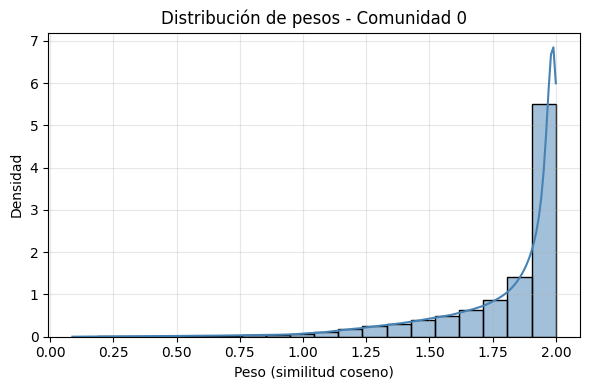


Comunidad 1: 938 nodos, 351861 aristas internas
  Peso promedio: 1.496, desviación: 0.519


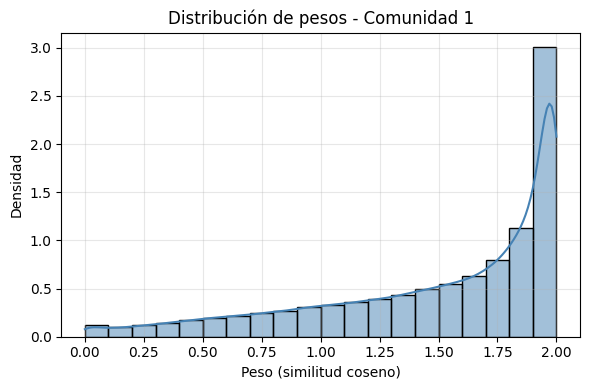

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from networkx.algorithms.community import modularity

# Detectar comunidades con Louvain
comunidades = nx.algorithms.community.louvain_communities(G)

# Mostrar información básica
for i, comunidad in enumerate(comunidades):
    print(f"Comunidad {i}: {len(comunidad)} nodos")

# Calcular modularidad total
Q = modularity(G, comunidades)
print("Modularidad:", Q)

# --- Distribución de pesos por comunidad ---
pesos_por_comunidad = []

for i, comunidad in enumerate(comunidades):
    # Subgrafo de la comunidad
    subG = G.subgraph(comunidad)
    
    # Obtener los pesos de las aristas internas
    pesos = [d['weight'] for (_, _, d) in subG.edges(data=True) if 'weight' in d]
    pesos_por_comunidad.append(pesos)
    
    # Mostrar estadísticas básicas
    print(f"\nComunidad {i}: {len(comunidad)} nodos, {len(pesos)} aristas internas")
    print(f"  Peso promedio: {np.mean(pesos):.3f}, desviación: {np.std(pesos):.3f}")
    
    # Crear gráfico individual
    plt.figure(figsize=(6,4))
    sns.histplot(pesos, bins=20, kde=True,stat='density', color="steelblue")
    plt.title(f"Distribución de pesos - Comunidad {i}")
    plt.xlabel("Peso (similitud coseno)")
    plt.ylabel("Densidad")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

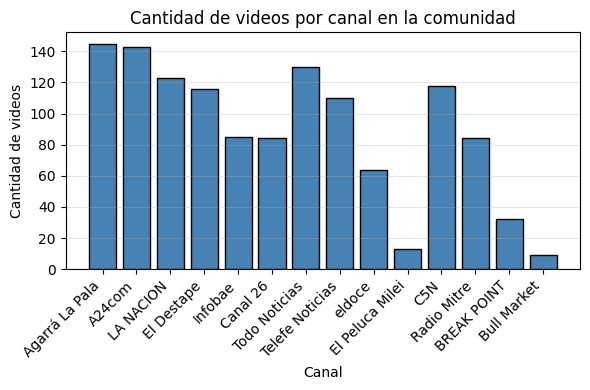

In [6]:
from collections import Counter
comunidad_0=comunidades[0]
# Separar el nombre del canal (todo lo que está antes del "_")
canales = [video.split("_")[0] for video in comunidad_0]

# Contar cuántos videos hay por canal
conteo_canales = Counter(canales)

# Convertir a listas ordenadas
canales = list(conteo_canales.keys())
cantidades = list(conteo_canales.values())

# --- Gráfico de barras vertical ---
plt.figure(figsize=(6,4))
plt.bar(canales, cantidades, color="steelblue", edgecolor="black")

plt.title("Cantidad de videos por canal en la comunidad")
plt.xlabel("Canal")
plt.ylabel("Cantidad de videos")
plt.xticks(rotation=45, ha='right')  # rotar etiquetas para que no se superpongan
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Distribucion Pesos

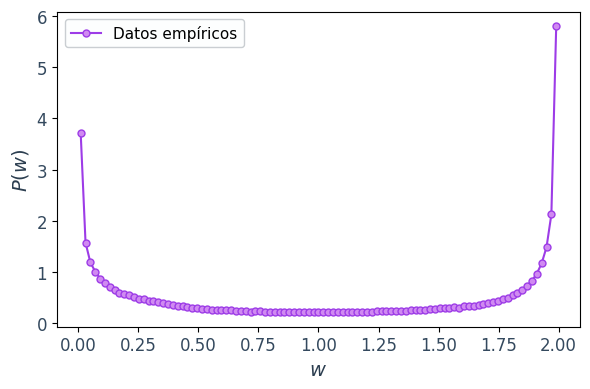

In [7]:
pesos_dict = nx.get_edge_attributes(G, 'weight')
w=list(pesos_dict.values())
x,y=linbin_pdf(w)
    # --- Plot ---
plt.figure(figsize=(6,4))

    # --- Curva principal (datos empíricos) ---
plt.plot(
        x, y, "o-", 
        color="#9D3CE7",      # rojo suave
        markersize=5,
        markerfacecolor="#D08AF1",
        label="Datos empíricos"
    )
ax = plt.gca()
ax.set_facecolor("none")
    # --- Etiquetas y estilo de ejes ---
plt.xlabel(r"$w$", fontsize=14, color="#2C3E50")
plt.ylabel(r"$P(w)$", fontsize=14, color="#2C3E50")
plt.xticks(fontsize=12, color="#34495E")
plt.yticks(fontsize=12, color="#34495E")

    # --- Cuadro de leyenda ---
plt.legend(
        fontsize=11,
        frameon=True,
        facecolor="#FDFEFE",
        edgecolor="#BDC3C7",
        loc="best"
    )
plt.tight_layout()
plt.savefig("Distribucion_pesos_sent.pdf", format='pdf', bbox_inches="tight")
plt.show()



# Distribucion Grados

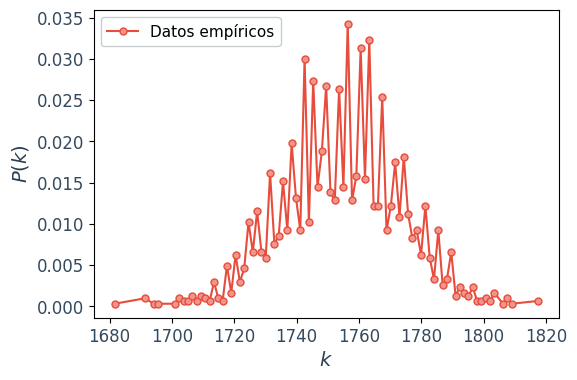

In [8]:
grados=[d for _,d in G.degree()]
#Calculo de mediana,media y desvio
mediana=np.median(grados)
media = np.mean(grados)
desvio = np.std(grados)

# --- Distribución log-bineada ---
x, y = linbin_pdf(grados)

# --- Plot ---
plt.figure(figsize=(6,4))

# --- Curva principal (datos empíricos) ---
plt.plot(
    x, y, "o-", 
    color="#E74C3C",      # rojo suave
    markersize=5,
    markerfacecolor="#F1948A",
    label="Datos empíricos"
)

# --- Escalas logarítmicas ---
# plt.xscale("log")
# plt.yscale("log")
ax = plt.gca()
ax.set_facecolor("none")

# --- Etiquetas y estilo de ejes ---
plt.xlabel(r"$k$", fontsize=14, color="#2C3E50")
plt.ylabel(r"$P(k)$", fontsize=14, color="#2C3E50")
plt.xticks(fontsize=12, color="#34495E")
plt.yticks(fontsize=12, color="#34495E")

# --- Cuadro de leyenda ---
plt.legend(
    fontsize=11,
    frameon=True,
    facecolor="#FDFEFE",
    edgecolor="#BDC3C7",
    loc="upper left"
)


# Distribucion Centralidad

In [9]:
output_dir = "grafo_sentimientos_eigenvector"
os.makedirs(output_dir, exist_ok=True)

# Lista de porcentajes
for p in [30, 40, 50, 60, 70, 80]:
    # Construir grafo con p% de aristas
    G = construir_red_global_sentimientos(
        n_videos_por_canal=100,
        umbral_similitud=0,
        cantidad_aristas=p
    )
    
    # Calcular centralidad de eigenvector
    centrality = nx.eigenvector_centrality(G)
    c_values = list(centrality.values())
    
    # Crear histograma
    plt.figure(figsize=(6,4))
    plt.hist(c_values, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"{p}% de aristas")
    plt.xlabel("Centralidad de eigenvector")
    plt.ylabel("Frecuencia")
    
    # Guardar gráfico
    filename = f"centralidad_eigenvector_{p}porciento.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

In [10]:
output_dir = "grafo_sentimientos_clustering"
os.makedirs(output_dir, exist_ok=True)

# Lista de porcentajes
for p in [30, 40, 50, 60, 70, 80]:
    # Construir grafo con p% de aristas
    G = construir_red_global_sentimientos(
        n_videos_por_canal=100,
        umbral_similitud=0,
        cantidad_aristas=p
    )
    
    # Calcular centralidad de eigenvector
    clustering = nx.clustering(G)
    clustering_values = list(clustering.values())
    
    # Crear histograma
    plt.figure(figsize=(6,4))
    plt.hist(clustering_values, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"{p}% de aristas")
    plt.xlabel("clustering")
    plt.ylabel("Frecuencia")
    
    # Guardar gráfico
    filename = f"clustering_{p}porciento.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

In [11]:
c_c=nx.clustering(G)

In [12]:
val_c=list(c_c.values())
print(set(val_c))
# x_c,y_c=linbin_pdf(val_c)
# print(y_c)
# plt.plot(x_c,y_c,"o-")

{0.8005785785785786, 0.8000297280941107, 0.7997316357735755, 0.8001872647512513, 0.8001202743886902, 0.7996377870902771, 0.7996336336336336, 0.7997169704057434, 0.7997302309206944, 0.7995470462770511, 0.7993004828525443, 0.7992365152077917, 0.8002144494878217, 0.79969853360792, 0.8003255197409266, 0.8004637904437504, 0.8003384094754653, 0.8002994694183132, 0.799776618599655, 0.8004787197214721, 0.8003590784771045, 0.8001635525127181, 0.8005412890231621, 0.8002270782529063, 0.7999940536362015, 0.7997120460726284, 0.7998814280609428, 0.8004569126950486, 0.7994659176747204, 0.800151458391238, 0.7999923002263328, 0.7999114506646349, 0.7997977945008442, 0.8006099863136533, 0.7998474748178601, 0.800352364831874, 0.7998088908235744, 0.8003255701956008, 0.7996922494390802, 0.8003862370201106, 0.8007820560439107, 0.7998618795953982, 0.8006155274363786, 0.7994710898278871, 0.8002121065475026, 0.7998102524004881, 0.7994936320710738, 0.8001010956927362, 0.79896530219433, 0.8000400147422735, 0.8001

(array([  3.,  30., 104., 270., 315., 280., 164.,  57.,  11.,   1.]),
 array([0.79888669, 0.79912237, 0.79935806, 0.79959374, 0.79982942,
        0.8000651 , 0.80030079, 0.80053647, 0.80077215, 0.80100784,
        0.80124352]),
 <BarContainer object of 10 artists>)

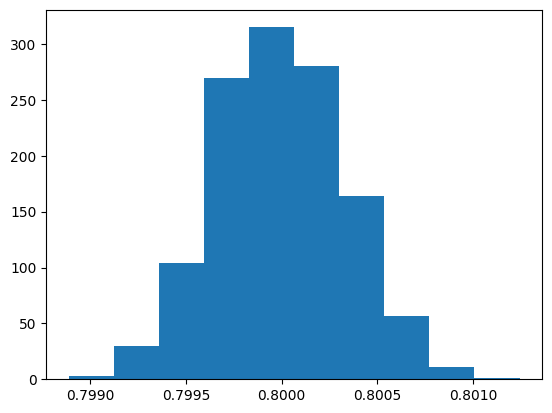

In [13]:
plt.hist(val_c)

# Distribucion eigenvector

In [14]:
centrality=nx.eigenvector_centrality(G)
c_values=list(centrality.values())

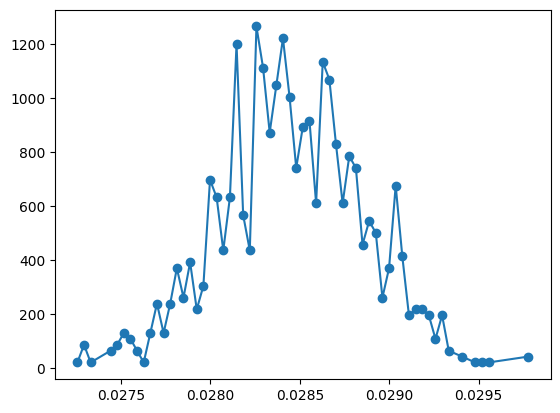

In [15]:
x_cen,y_cen=linbin_pdf(c_values,nbin=70)
plt.plot(x_cen,y_cen,"o-")

# Distribucion beetweenes centrality

In [16]:
betw_cen=nx.betweenness_centrality(G)

In [17]:
print(betw_cen)

{'A24com_6QhKL7C_LRw': 0.00016594209724876867, 'A24com_DrvDdtchJYo': 0.00016857949182417294, 'A24com_dTeC1_B-lrA': 0.00016945485693896066, 'A24com_5JllVQijb2Q': 0.00016544137778318047, 'A24com_R3J__fQ34rk': 0.00016025574249107474, 'A24com_ny3nbcJvxms': 0.0001658323539398428, 'A24com_Y7gTpcbrm7A': 0.00016108238216505836, 'A24com_oT1h8s9qRWg': 0.0001568906657956334, 'A24com_BI19XlpVoAA': 0.00016470214520679236, 'A24com_CUxnOxj56RY': 0.00015509891205660656, 'A24com_mCuQTmRMVjM': 0.00015993379737775992, 'A24com_1adSbxlf5Aw': 0.00017224795456834786, 'A24com_VUxXPFieSxQ': 0.00016358367590045474, 'A24com_dkPcvvhDQKI': 0.00017126591690061176, 'A24com_9aV9I7i8t1A': 0.0001587658222649563, 'A24com_bDrsWmrHuLs': 0.00016702544394368735, 'A24com_SGQiCWnukt4': 0.00016019028967736792, 'A24com_rO0eeTi5yQI': 0.00016191529876530468, 'A24com_anrv9oIDY4U': 0.00016000600952451036, 'A24com_q9QeK1hyo70': 0.0001628251821059345, 'A24com_-QEkXkJ_hO8': 0.0001611521186102653, 'A24com_mSNEj2aic3I': 0.00015481105037

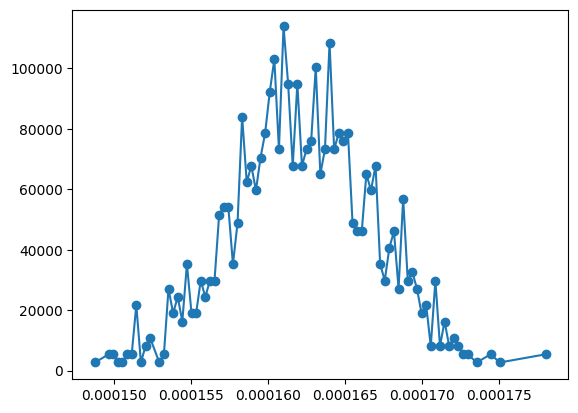

In [18]:
bc_lis=list(betw_cen.values())
x_bc,y_bc=linbin_pdf(bc_lis)
plt.plot(x_bc,y_bc,"o-")

79 60


ValueError: x and y must have same first dimension, but have shapes (66,) and (60,)

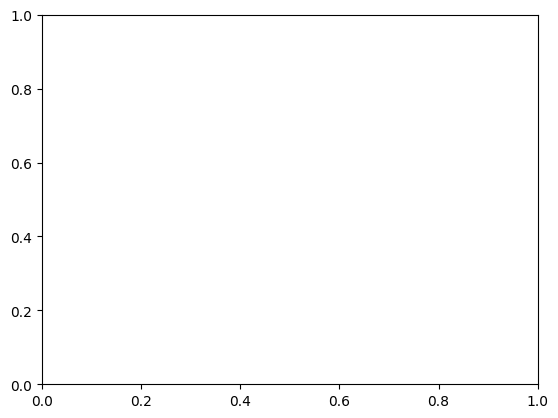

In [19]:
x_clus,y_clus=linbin_pdf(val_c)
print(len(x_clus),len(x_cen))
plt.plot(x_clus[:66],x_cen,"o")

In [ ]:
s="Elena"
print("m" in s)

False
